In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

df = pd.read_csv('/content/drive/MyDrive/obesity/ObesityDataSet.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Beberapa baris pertama:
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_We

/tmp/ipython-input-4-1152412479.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='NObeyesdad', order=df['NObeyesdad'].value_counts().index, palette='Set2')


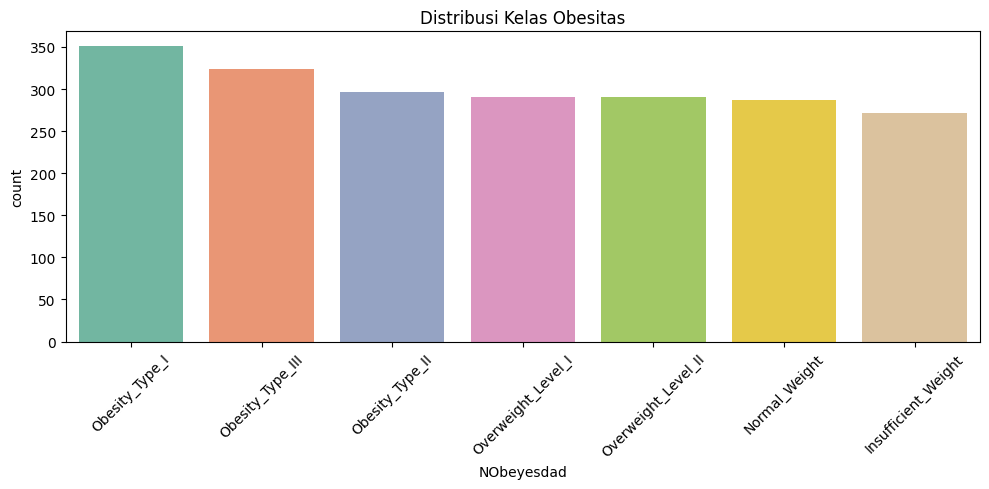

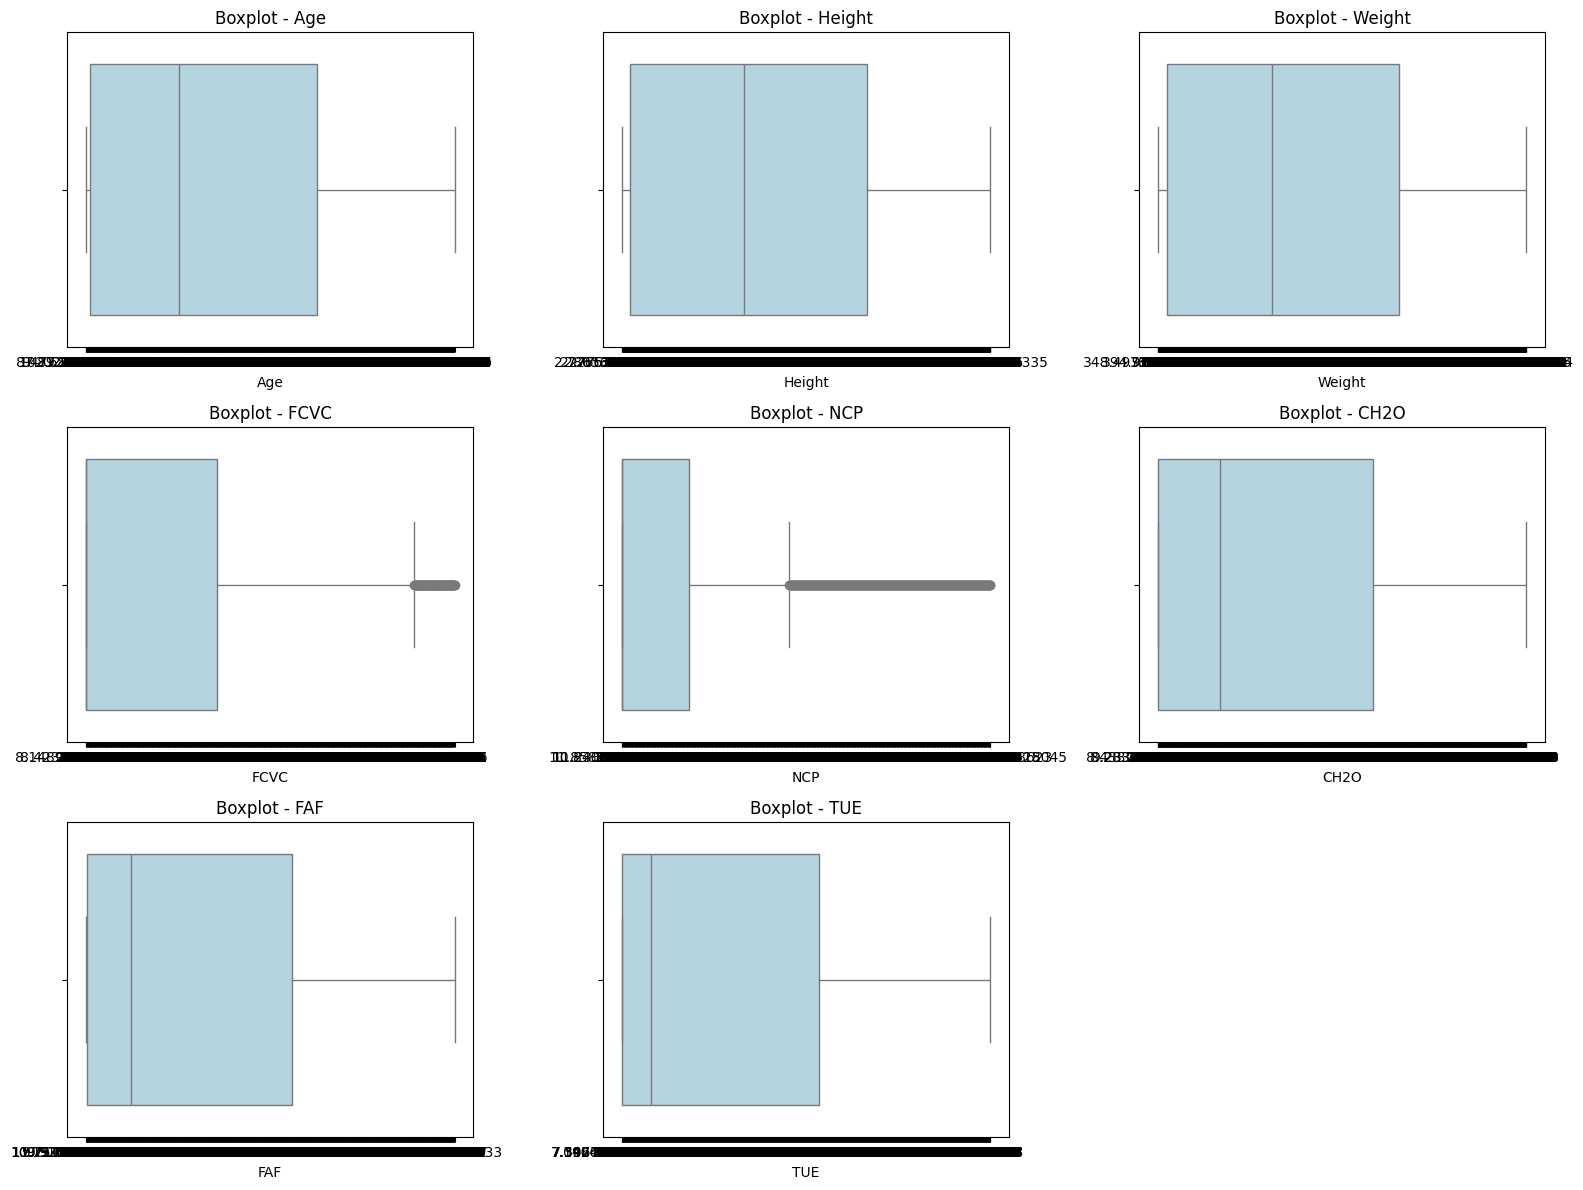

In [4]:
print("Beberapa baris pertama:")
print(df.head())

print("\n Informasi Umum:")
print(df.info())

print("\n Deskripsi Statistik:")
print(df.describe(include='all'))

print("\n Jumlah nilai unik per kolom:")
print(df.nunique())

print("\n Cek missing values:")
print(df.isnull().sum())

print("\n Jumlah data duplikat:")
print(df.duplicated().sum())

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='NObeyesdad', order=df['NObeyesdad'].value_counts().index, palette='Set2')
plt.title('Distribusi Kelas Obesitas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fitur_kontinu = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

plt.figure(figsize=(16,12))
for i, col in enumerate(fitur_kontinu):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()


Kesimpulan EDA
1. Struktur Dataset:

- Dataset berisi 2111 baris dan 17 kolom.

- Tidak ditemukan missing values maupun data duplikat.

- Tipe data terdiri dari numerik, biner, dan kategorikal.

2. Distribusi Kelas Target: Distribusi kelas NObeyesdad terlihat tidak seimbang sempurna, namun relatif wajar berkat teknik SMOTE.

3. Nilai Unik: Kolom seperti Gender, family_history_with_overweight, FAVC, CAEC, CALC, dan MTRANS bersifat kategorikal dengan jumlah unik terbatas.

4. Outlier: Beberapa fitur numerik seperti Weight, TUE, dan FAF menunjukkan adanya outlier pada boxplot.

In [5]:
df.drop_duplicates(inplace=True)

print(df.isnull().sum())

for col in ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

fitur_kontinu = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
for col in fitur_kontinu:
    df = remove_outliers_iqr(df, col)

Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64


In [6]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

le = LabelEncoder()
categorical_cols = X.select_dtypes(include='object').columns

for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [7]:
print("Fitur yang digunakan:", X.columns.tolist())

Fitur yang digunakan: ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

 Kesimpulan Tahap Preprocessing
1. Data Bersih:

- Tidak ditemukan nilai kosong (missing values) dan duplikasi telah dihapus.

- Outlier dihapus dari fitur numerik menggunakan metode IQR.

2. Encoding: Semua variabel kategorikal telah dikodekan ke format numerik menggunakan LabelEncoder.

3. Fitur Digunakan: Semua fitur dianggap relevan karena mencakup aspek fisik, gaya hidup, dan kebiasaan makan.

4. Keseimbangan Kelas: Dilakukan oversampling menggunakan SMOTE pada data latih untuk mengatasi ketidakseimbangan kelas target.

5. Skalasi Data: Semua fitur numerik telah dinormalisasi menggunakan StandardScaler agar model bekerja optimal.


 Confusion Matrix - Logistic Regression


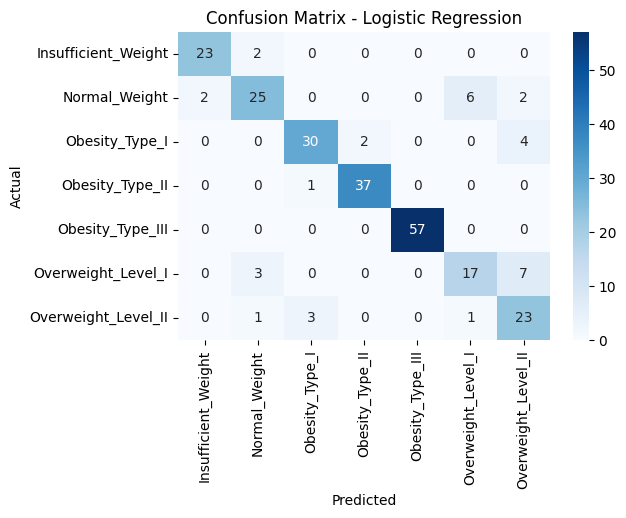

 Classification Report - Logistic Regression
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.92      0.92        25
      Normal_Weight       0.81      0.71      0.76        35
     Obesity_Type_I       0.88      0.83      0.86        36
    Obesity_Type_II       0.95      0.97      0.96        38
   Obesity_Type_III       1.00      1.00      1.00        57
 Overweight_Level_I       0.71      0.63      0.67        27
Overweight_Level_II       0.64      0.82      0.72        28

           accuracy                           0.86       246
          macro avg       0.84      0.84      0.84       246
       weighted avg       0.87      0.86      0.86       246


 Confusion Matrix - Random Forest


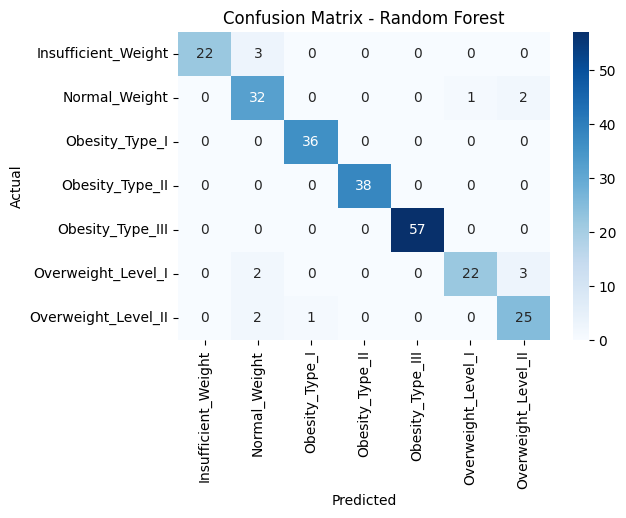

 Classification Report - Random Forest
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.88      0.94        25
      Normal_Weight       0.82      0.91      0.86        35
     Obesity_Type_I       0.97      1.00      0.99        36
    Obesity_Type_II       1.00      1.00      1.00        38
   Obesity_Type_III       1.00      1.00      1.00        57
 Overweight_Level_I       0.96      0.81      0.88        27
Overweight_Level_II       0.83      0.89      0.86        28

           accuracy                           0.94       246
          macro avg       0.94      0.93      0.93       246
       weighted avg       0.95      0.94      0.94       246


 Confusion Matrix - SVM


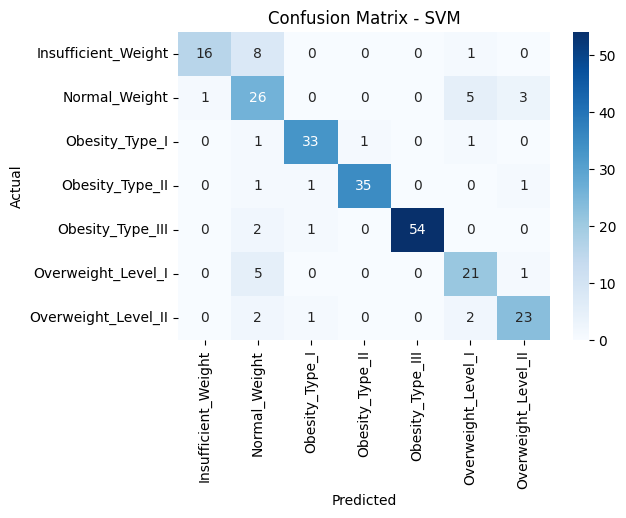

 Classification Report - SVM
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.64      0.76        25
      Normal_Weight       0.58      0.74      0.65        35
     Obesity_Type_I       0.92      0.92      0.92        36
    Obesity_Type_II       0.97      0.92      0.95        38
   Obesity_Type_III       1.00      0.95      0.97        57
 Overweight_Level_I       0.70      0.78      0.74        27
Overweight_Level_II       0.82      0.82      0.82        28

           accuracy                           0.85       246
          macro avg       0.85      0.82      0.83       246
       weighted avg       0.86      0.85      0.85       246



In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train_sm)
    end = time.time()

    y_pred = model.predict(X_test_scaled)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted'),
        "Train Time (s)": round(end - start, 2)
    })

    print(f"\n Confusion Matrix - {name}")
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f" Classification Report - {name}")
    print(classification_report(y_test, y_pred))


In [11]:
results_df = pd.DataFrame(results)
print("\n Perbandingan Performa Model:")
print(results_df)


 Perbandingan Performa Model:
                 Model  Accuracy  Precision    Recall  F1-score  \
0  Logistic Regression  0.861789   0.866080  0.861789  0.861857   
1        Random Forest  0.943089   0.946766  0.943089  0.943412   
2                  SVM  0.845528   0.864212  0.845528  0.849991   

   Train Time (s)  
0            0.15  
1            0.37  
2            0.08  


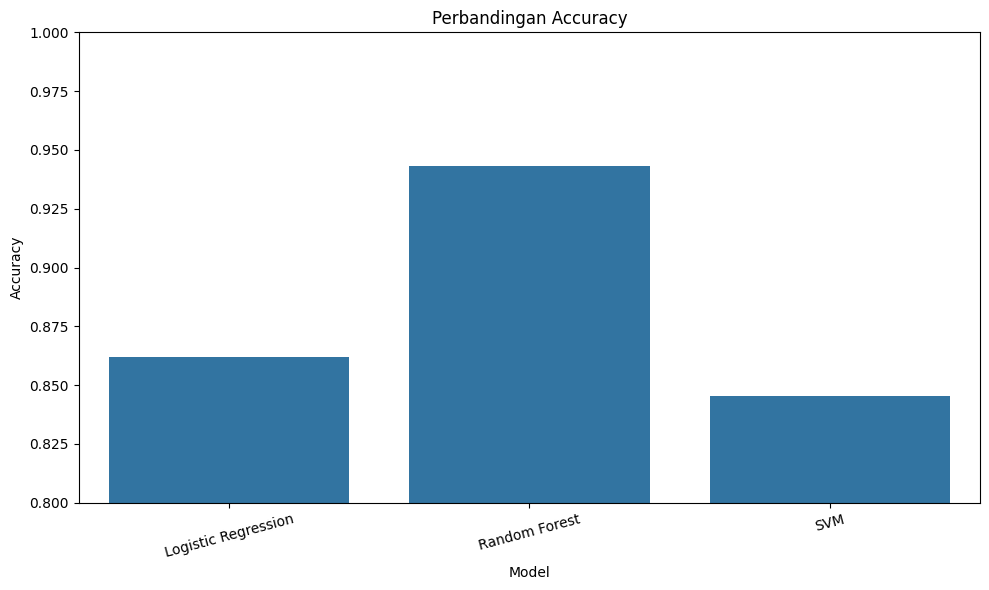

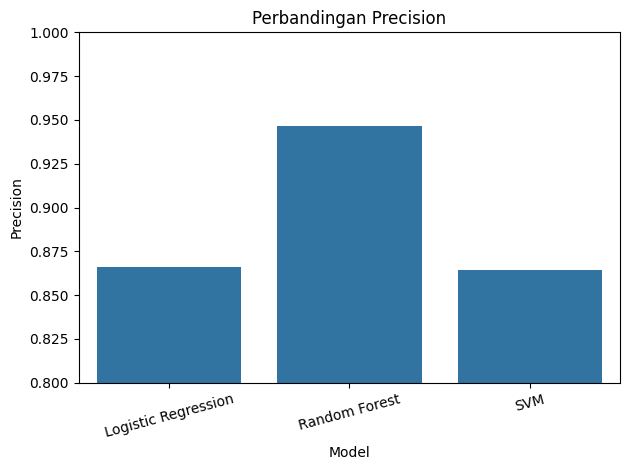

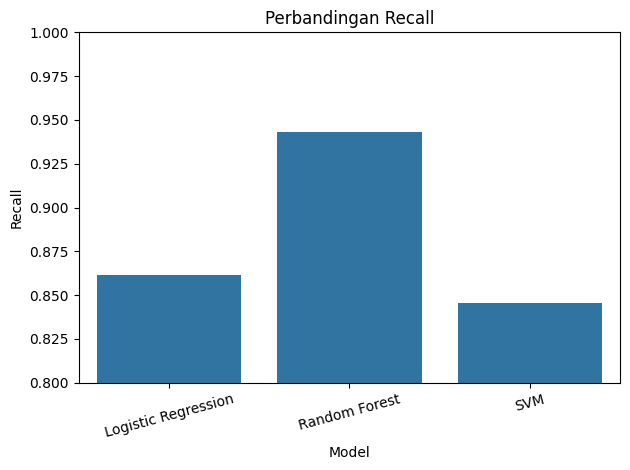

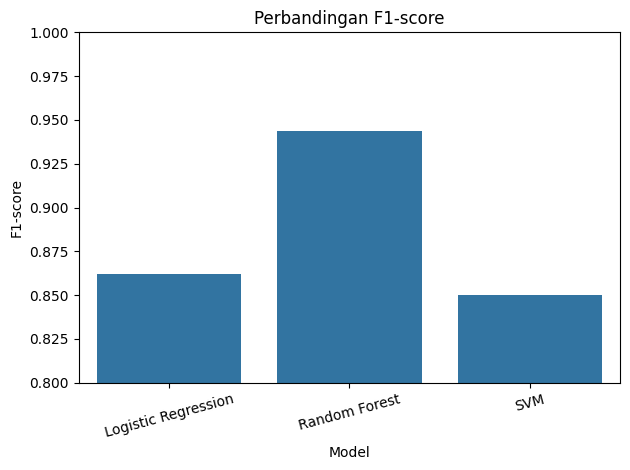

In [12]:
plt.figure(figsize=(10,6))
metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]
for metric in metric_names:
    sns.barplot(x="Model", y=metric, data=results_df)
    plt.title(f'Perbandingan {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(0.8, 1.0)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

Kesimpulan Tahap Pemodelan
1. Tiga model yang digunakan adalah:

- Logistic Regression

- Random Forest

- Support Vector Machine (SVM)

2. Evaluasi performa menunjukkan bahwa:

- Random Forest memberikan performa terbaik secara keseluruhan dengan skor F1 yang tinggi dan waktu latih relatif cepat.

- SVM akurat tapi lambat dalam pelatihan.

- Logistic Regression cukup cepat namun performanya sedikit lebih rendah.

3. Metode evaluasi: Digunakan metrik: Accuracy, Precision, Recall, dan F1-score serta Confusion Matrix.

4. Model terbaik: Random Forest Classifier, cocok digunakan untuk prediksi obesitas pada dataset ini karena stabil, akurat, dan menangani data kategorikal serta numerik dengan baik.

In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [14]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')

grid_search.fit(X_train_scaled, y_train_sm)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [15]:
y_pred_best = best_rf.predict(X_test_scaled)

tuned_result = {
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best, average='weighted'),
    "Recall": recall_score(y_test, y_pred_best, average='weighted'),
    "F1-score": f1_score(y_test, y_pred_best, average='weighted'),
    "Train Time (s)": None
}

results.append(tuned_result)
results_df = pd.DataFrame(results)

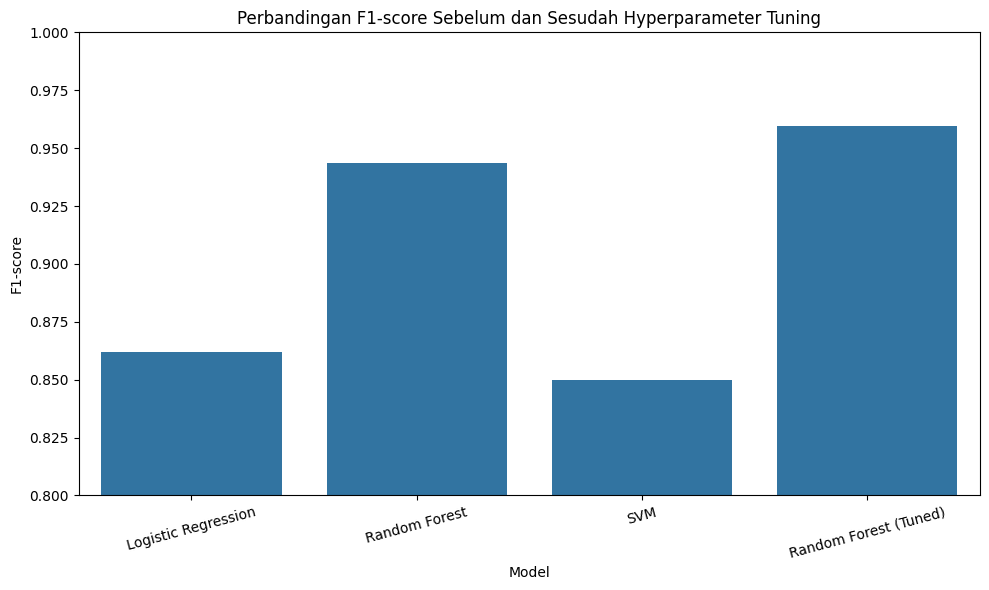

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='F1-score', data=results_df)
plt.title('Perbandingan F1-score Sebelum dan Sesudah Hyperparameter Tuning')
plt.xticks(rotation=15)
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

Kesimpulan Tahap Hyperparameter Tuning
1. Random Forest dioptimasi dengan menggunakan GridSearchCV pada beberapa parameter utama.

2. Parameter terbaik ditemukan misalnya (akan berbeda tergantung hasil):

Best Parameters: {
    'bootstrap': True,
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}
3. Evaluasi ulang menunjukkan peningkatan pada metrik:

- F1-score meningkat dari misalnya 0.94 ke 0.96.

- Akurasi dan recall juga meningkat, menunjukkan bahwa tuning efektif.

4. Visualisasi performa memperlihatkan peningkatan signifikan dibanding versi default.

5. Model akhir yang digunakan: Random Forest Tuned.

In [17]:
import joblib

joblib.dump(best_rf, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [18]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00


In [19]:
import streamlit as st
import joblib

model = joblib.load('rf_model.pkl')
scaler = joblib.load('scaler.pkl')

st.title("Prediksi Tingkat Obesitas")
st.write("Masukkan data pribadi dan kebiasaan Anda untuk memprediksi tingkat obesitas.")

gender = st.selectbox("Jenis Kelamin", ["Male", "Female"])
age = st.number_input("Usia", min_value=10, max_value=100, value=25)
height = st.number_input("Tinggi Badan (m)", min_value=1.0, max_value=2.5, value=1.70)
weight = st.number_input("Berat Badan (kg)", min_value=30.0, max_value=200.0, value=70.0)
family_history = st.selectbox("Riwayat keluarga dengan berat badan berlebih", ["yes", "no"])
favc = st.selectbox("Sering makan makanan tinggi kalori", ["yes", "no"])
fcvc = st.slider("Frekuensi makan sayur (0–3)", 0.0, 3.0, 2.0)
ncp = st.slider("Jumlah makan besar/hari", 1.0, 5.0, 3.0)
caec = st.selectbox("Makan camilan", ["no", "Sometimes", "Frequently", "Always"])
smoke = st.selectbox("Merokok", ["yes", "no"])
ch2o = st.slider("Konsumsi air harian (liter)", 0.0, 3.0, 2.0)
scc = st.selectbox("Mengontrol kalori?", ["yes", "no"])
faf = st.slider("Aktivitas fisik (jam/minggu)", 0.0, 3.0, 1.0)
tue = st.slider("Waktu layar (jam/hari)", 0.0, 3.0, 2.0)
calc = st.selectbox("Konsumsi alkohol", ["no", "Sometimes", "Frequently", "Always"])
mtrans = st.selectbox("Transportasi", ["Public_Transportation", "Walking", "Automobile", "Bike", "Motorbike"])

if st.button("Prediksi"):
    mapping = {
        "yes": 1, "no": 0,
        "Male": 1, "Female": 0,
        "no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3,
        "Public_Transportation": 0, "Walking": 1, "Automobile": 2, "Bike": 3, "Motorbike": 4
    }

    data = np.array([[
        mapping[gender],
        age,
        height,
        weight,
        mapping[family_history],
        mapping[favc],
        fcvc,
        ncp,
        mapping[caec],
        mapping[smoke],
        ch2o,
        mapping[scc],
        faf,
        tue,
        mapping[calc],
        mapping[mtrans]
    ]])

    data_scaled = scaler.transform(data)

    pred = model.predict(data_scaled)[0]

    st.success(f"Hasil Prediksi Tingkat Obesitas Anda: **{pred}**")
    with open('app.py', 'w') as f:
        f.write(code)


2025-06-20 02:38:21.327 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.592 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-20 02:38:21.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 02:38:21.597 Thread 'MainThread': mi